In [1]:
import yfinance as yf
import time

import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta


from ta.momentum import roc
from ta.momentum import RSIIndicator,rsi
from ta.trend import wma_indicator, ema_indicator
from ta.utils import dropna

import warnings
warnings.filterwarnings('ignore')

# Portfolio Strategy

In our investment approach, we employ a momentum-based strategy that harnesses the power of both the Coppock Curve and the RSI (Relative Strength Index) indicators.Our primary objective is to dynamically rebalance our portfolio in response to generated signals.By doing so, we aim to allocate capital optimally, aligning our investments with the prevailing market momentum to potentially enhance returns and manage risks.

## Core Trading Strategy

Combination of a momentum indicator **Coppock Curve** with a mean-reversion indictor **RSI**. 

Dual-indicator approach that leverages the strengths of both the Coppock Curve and the RSI to maximize trading opportunities. This strategy is designed to harness the Coppock Curve's ability to identify long-term trend reversals and the RSI's sensitivity to short-term price movements. This combination allows traders to align themselves with the overall market momentum while pinpointing optimal entry points for trades. Ultimately, offering a more holistic view of the market and potentially filter out false signals.


## Decoding the Signals
We will use Coppock Curve and RSI to each generate a value. 1 or -1. 

### Coppock curve [1,-1]
1 is generated when Coppock Curve crosses above zero. This indicates that the momentum has shifted from negative (bearish) to positive (bullish), suggesting that it might be a good time to buy.
-1 is generated when the Coppock Curve crosses below zero. This suggests that the momentum has shifted from positive (bullish) to negative (bearish), which might indicate that it might be a good time to short.

### RSI [1,-1]
40/70 We will use the values 40 to indicate oversold and 70 to indicate overbought.
1 is generated when RSI crossed above 40 from below or if RSI >50
-1 is generated when RSI crossed below 70 from above or if RSI <50

Combining the values generated by Coppock Curve and RSI
We will be able to generate the absolute value (strength of signal) denoting the confidence and direction of the signal

```python
- Strong Buy Signal: (1,1) -> Score:` [2] `
- Weak Buy Signal: (1,-1) -> Score: ` [0] `
- Weak Sell Signal: (-1,1) -> Score: ` [0] `
- Strong Sell Signal: (-1,-1) -> Score: ` [-2] `
```

## Portfolio Weights and Capital Allocation

Our strategy goes a step further by converting these scores into weights relative to the portfolio. This is instrumental in determining the capital allocation for each stock, ensuring optimal diversification and risk management. The weights are as follows:

```python

Score of ` [2] ` translates to a weight of 3. #Strong Bullish Signal

Score of ` [0] ` translates to a weight of 2. #Weak Neutral Signal

Score of ` [-2] ` translates to a weight of 1. #Strong Bearish Signal

```

We will then use the weights given to the stock to generate the capital allocated for each stock.
Capital of Stock x = Weights of Stock x / Sum of weights of all stock

## Variations of Coppock Curve

1. **Coppock Curve with standard sets of 2 periods**: The standard Coppock Curve uses a 14-day period for the long Rate of Change (RoC) and an 11-day period for the short RoC. An alternative configuration might be to use a 21-day period for the long RoC and a 5-day period for the short RoC.

2. **Coppock Curve with different smoothing constants**: The standard Coppock Curve uses a 10-period Weighted Moving Average (WMA) for smoothing.
Alternative configurations might use a different period for the WMA.

3. The standard Coppock Curve uses a **Weighted Moving Average (WMA)** for smoothing.

In [2]:
# Strategy Logic
# Coppock Curve and RSI strategy

def get_cc_wma(df,roc1_n,roc2_n,wma_lookback):
    cc_wma = wma_indicator((roc(close=df['Close_Price'], window=roc1_n,fillna= False)) + (roc(close=df['Close_Price'], window=roc2_n,fillna= False)), window=wma_lookback,fillna= False)
    return cc_wma

def get_rsi(df,window):
    rsi_indicator = rsi(close=df['Close_Price'], window=window,fillna= False)
    return rsi_indicator

def CC_RSI_strategy(df,num):
    wma = 10
    for var in range(1,num+1):
        df[f'cc_{var}'] = get_cc_wma(df, 14, 11, wma)
        wma += 40
    df['rsi_14'] = get_rsi(df, 14)
    df = df.dropna()

    for var in range(1,num+1):
        cc_crossed_above_zero = False
        rsi_crossed_40_below = False
        rsi_crossed_70_above = False
        val = [1]
        for day in range(1,len(df)):
            # Generate strat
            cc_current = df.iloc[day][f'cc_{var}']
            cc_prev = df.iloc[day-1][f'cc_{var}']
            rsi_current = df.iloc[day]['rsi_14']
            rsi_prev = df.iloc[day-1]['rsi_14']
            if cc_crossed_above_zero:
                # check rsi
                if rsi_crossed_40_below or rsi_current > 50:
                    val.append(6)
                elif rsi_crossed_70_above or rsi_current < 50:
                    val.append(4)
                else:
                    val.append(1)

                if cc_current <= 0:
                    cc_crossed_above_zero = False
                if rsi_current < 40:
                    rsi_crossed_40_below = False
                if rsi_current > 70:
                    rsi_crossed_70_above = False
                # continue
            else:
                if rsi_crossed_40_below or rsi_current > 50:
                    val.append(1)
                elif rsi_crossed_70_above or rsi_current < 50:
                    val.append(4)
                else:
                    val.append(6)  
            # Check if CC has crossed above zero
            if cc_current > 0 and cc_prev <= 0:
                cc_crossed_above_zero = True
            else:
                cc_crossed_above_zero = False

            # Check if RSI has crossed 40 from below
            if rsi_current > 40 and rsi_prev <= 40:
                rsi_crossed_40_below = True
            else:
                rsi_crossed_40_below = False

            # Check if RSI has crossed 70 from above
            if rsi_current < 70 and rsi_prev >= 70:
                rsi_crossed_70_above= True
            else:
                rsi_crossed_70_above = False

        df[f'cc_{var}_val'] = val
        df[f'cc_{var}_qty'] = None
    return df
    

# Portfolio Class

The `Portfolio` class is designed to manage a portfolio of stocks and backtest trading strategies on the collection of stocks over historical data.

## Class Initialization

```python
class Portfolio():
    def __init__(self, stocks, capital, variations):
        ...
```

- **Attributes**:
  - **stocks**: A dictionary of stock symbols and their associated `Stock` objects.
  - **capital**: Initial investment capital.
  - **variations**: Different strategies or variations to test.
  - **dataframe**: A DataFrame to record portfolio's daily values.

## Core Methods

```python
    def initialise_capital(self):
        ...
        
    def calculate_weights(self, date, var):
        ...

    def generate_weightage(self, dates):
        ...
        
    def run_simulation(self, dates):
        ...
        
    def close_positions(self, today_date, prev_date):
        ...
```

- **initialise_capital**: Sets up the initial capital for each variation.
- **calculate_weights**: Computes the weights for stocks in the portfolio based on their respective signals.
- **generate_weightage**: Normalizes weights for stocks daily.
- **run_simulation**: Simulates the trades over a given date range.
- **close_positions**: Closes any open stock positions.

## Performance Metrics

```python
    def calc_risk_return(self):
        ...
        
    def calculate_returns(self, benchmark_symbol):
        ...
        
    def max_drawdown(self):
        ...
        
    def plot_drawdown(self):
        ...
        
    def compute_calmar_ratio(self):
        ...
        
    def compute_alpha_beta(self, benchmark_symbol):
        ...
```

- **calc_risk_return**: Calculates risk and return metrics for the portfolio.
- **calculate_returns**: Computes daily and log returns for the portfolio.
- **max_drawdown**: Determines the maximum drawdown experienced in the portfolio.
- **plot_drawdown**: Visualizes the drawdown.
- **compute_calmar_ratio**: Calculates the Calmar ratio.
- **compute_alpha_beta**: Computes the Alpha and Beta against a benchmark.

## Additional Methods

```python
    def add_benchmark(self, benchmark_symbol):
        ...
```

- **add_benchmark**: Adds a benchmark stock to the portfolio to compare performance.

---

This `Portfolio` class provides the foundation for simulating trading strategies on a collection of stocks, assessing their performance, and comparing against benchmarks.


In [3]:
class Portfolio():
    def __init__(self, stocks, capital, variations):
        self.stocks = stocks
        self.dataframe = pd.DataFrame()  # load this dataframe sequentially everyday
        self.capital = capital  # this capital will change depending on trades
        self.variations = variations
        self.initialise_capital()

    def calc_risk_return(self,benchmark_symbol,df):
        results = []
        
        for i in range(1, self.variations + 1):
            column_prefix = f'Portfolio_{i}_Log_Returns'

            # 1. Annual Returns
            daily_ret = df[column_prefix].mean()
            annual_ret = daily_ret * 252
            annual_regular_ret = np.exp(annual_ret) - 1

            # 2. Annual Standard deviation
            daily_std = df[column_prefix].std()
            annual_std = daily_std * (252 ** 0.5)
            daily_regular_std = (np.exp(df[column_prefix]) - 1).std()
            annual_regular_std = daily_regular_std * (252 ** 0.5)

            # 3. Sharpe Ratio
            sr = annual_regular_ret / annual_regular_std

            results.append({
                f'Portfolio_{i}_annual_regular_returns': annual_regular_ret,
                f'Portfolio_{i}_annual_regular_std': annual_regular_std,
                f'Portfolio_{i}_annual_sharpe_ratio': sr
            })

        column_prefix = f'Benchmark_{benchmark_symbol}_Log_Returns'

        # 1. Annual Returns
        daily_ret = df[column_prefix].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        # 2. Annual Standard deviation
        daily_std = df[column_prefix].std()
        annual_std = daily_std * (252 ** 0.5)
        daily_regular_std = (np.exp(df[column_prefix]) - 1).std()
        annual_regular_std = daily_regular_std * (252 ** 0.5)

        # 3. Sharpe Ratio
        sr = annual_regular_ret / annual_regular_std

        results.append({
            f'Benchmark_{benchmark_symbol}_annual_regular_returns': annual_regular_ret,
            f'Benchmark_{benchmark_symbol}_annual_regular_std': annual_regular_std,
            f'Benchmark_{benchmark_symbol}_annual_sharpe_ratio': sr
        })
        # Extract data for each column
        returns = [portfolio[f'Portfolio_{i}_annual_regular_returns'] if f'Portfolio_{i}_annual_regular_returns' in portfolio else portfolio.get(f'Benchmark_{benchmark_symbol}_annual_regular_returns') for i, portfolio in enumerate(results, start=1)]
        std = [portfolio[f'Portfolio_{i}_annual_regular_std'] if f'Portfolio_{i}_annual_regular_std' in portfolio else portfolio.get(f'Benchmark_{benchmark_symbol}_annual_regular_std') for i, portfolio in enumerate(results, start=1)]
        sr = [portfolio[f'Portfolio_{i}_annual_sharpe_ratio'] if f'Portfolio_{i}_annual_sharpe_ratio' in portfolio else portfolio.get(f'Benchmark_{benchmark_symbol}_annual_sharpe_ratio') for i, portfolio in enumerate(results, start=1)]
        
        # returns = [portfolio.get(f'Portfolio_{i}_annual_regular_returns') for i, portfolio in enumerate(results, start=1)]
        # std = [portfolio.get(f'Portfolio_{i}_annual_regular_std') for i, portfolio in enumerate(results, start=1)]
        # sr = [portfolio.get(f'Portfolio_{i}_annual_sharpe_ratio') for i, portfolio in enumerate(results, start=1)]

        # Create DataFrame
        df_rr = pd.DataFrame({'Annual_regular_returns': returns, 'Annual_regular_std': std, 'Annual_sharpe_ratio': sr}, index=None)
        # Transpose the DataFrame and assign it back
        df_rr = df_rr.transpose()
        # Rename columns
        df_rr.columns = [f'Portfolio_{i}' if i < len(results) else f'Benchmark_{benchmark_symbol}' for i in range(1, len(results)+1)]
        # df.columns = [f'Portfolio_{i}' for i in range(1, len(results)+1)]
        return df_rr

    def calculate_returns(self,benchmark_symbol):
        self.dataframe[f'Benchmark_{benchmark_symbol}_Returns'] = self.dataframe[f'Benchmark_{benchmark_symbol}_close'].pct_change().dropna()
        self.dataframe[f'Benchmark_{benchmark_symbol}_Log_Returns'] = np.log(self.dataframe[f'Benchmark_{benchmark_symbol}_close'] / self.dataframe[f'Benchmark_{benchmark_symbol}_close'].shift(1))
        for i in range(1, self.variations + 1):
            portfolio_col = f'Portfolio_{i}_value'
                      
            #daily returns
            portfolio_daily_return_col = f'Portfolio_{i}_Daily_Returns'
            self.dataframe[portfolio_daily_return_col] = self.dataframe[portfolio_col].pct_change().dropna()
            
            #log returns
            log_return_col = f'Portfolio_{i}_Log_Returns'
            self.dataframe[log_return_col] = np.log(self.dataframe[portfolio_col] / self.dataframe[portfolio_col].shift(1))

    def max_drawdown(self):
        results = {}
        for i in range(1,self.variations+1):
            portfolio_col = f"Portfolio_{i}_Drawdown"
            max_drawdown = self.dataframe[portfolio_col].max()
            results[portfolio_col] = max_drawdown
        return results
    
    def plot_indiv_drawdown(self,benchmark_symbol):
        df = self.dataframe

        for i in range(1, self.variations + 1):
            # strat_returns
            df[f"Gross_Cum_Returns_{i}"] = df[f'Portfolio_{i}_Log_Returns'].cumsum().apply(np.exp) 
            df[f"Cum_Max_{i}"] = df[f"Gross_Cum_Returns_{i}"].cummax()
            df[[f"Gross_Cum_Returns_{i}", f"Cum_Max_{i}"]].dropna().plot(figsize =(15,6), title=f"Drawdown of {f'Portfolio_{i}'}")
            drawdown = df[f"Cum_Max_{i}"] - df[f"Gross_Cum_Returns_{i}"] # it gives the difference between orange and blue
            df[f"Portfolio_{i}_Drawdown"] = drawdown
        
        # Adding Benchmark drawdown
        df[f"Benchmark_{benchmark_symbol}_Gross_Cum_Returns"] = df[f"Benchmark_{benchmark_symbol}_Log_Returns"].cumsum().apply(np.exp)
        df[f"Benchmark_{benchmark_symbol}_Cum_Max"] = df[f"Benchmark_{benchmark_symbol}_Gross_Cum_Returns"].cummax()
        df[[f"Benchmark_{benchmark_symbol}_Gross_Cum_Returns", f"Benchmark_{benchmark_symbol}_Cum_Max"]].dropna().plot(figsize=(15, 6), title="Benchmark Drawdown")
        benchmark_drawdown = df[f"Benchmark_{benchmark_symbol}_Cum_Max"] - df[f"Benchmark_{benchmark_symbol}_Gross_Cum_Returns"]
        df[f"Benchmark_{benchmark_symbol}_Drawdown"] = benchmark_drawdown
    
    def plot_drawdown(self,benchmark_symbol):
        plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
        for i in range(1,self.variations+1):
            plt.plot(-1 * self.dataframe[f'Portfolio_{i}_Drawdown'], label=f'Portfolio_{i}_Drawdown')
        plt.plot(-1 * self.dataframe[f'Benchmark_{benchmark_symbol}_Drawdown'], label=f'Benchmark_{benchmark_symbol}_Drawdown')

        plt.title('Portfolio and Benchmark Drawdowns')
        plt.xlabel('Time')
        plt.ylabel('Drawdown')
        plt.legend()
        plt.show()


    def compute_calmar_ratio(self):
        max_drawdowns = self.max_drawdown()
        
        results = {}

        for i in range(1, self.variations + 1):
            portfolio_daily_return_col = f'Portfolio_{i}_Log_Returns'
            
            annualized_return = self.dataframe[portfolio_daily_return_col].mean() * 252            
            max_drawdown_value = max_drawdowns[f"Portfolio_{i}_Drawdown"]

            calmar_ratio = annualized_return /max_drawdown_value
            
            results[f'Portfolio_{i}'] = {
                'Calmar Ratio': calmar_ratio
            }

        return results
    
    def compute_sortino_ratio(self):
        
        results = {}
        for i in range(1, self.variations + 1):

            column_name = f'Portfolio_{i}_Log_Returns'
            
            # annualized avg rets
            mean_daily_return = self.dataframe[column_name].mean()
            annualized_return = mean_daily_return * 252
            
            # downside deviation
            negative_returns = self.dataframe[self.dataframe[column_name] < 0][column_name]
            downside_std = negative_returns.std() * np.sqrt(252)  # annualize the downside deviation

            if downside_std != 0:
                sortino_ratio = annualized_return / downside_std
            else:
                sortino_ratio = np.nan  # downside vol = 0
            
            results[f'Portfolio_{i}'] = {
                'Sortino Ratio': sortino_ratio
            }
            
        return results


    def compute_alpha_beta(self,benchmark_symbol):

        results = {}

        for i in range(1, self.variations + 1):
            portfolio_daily_return_col = f'Portfolio_{i}_Daily_Returns'
            
            # Beta
            returns = self.dataframe[[portfolio_daily_return_col, f'Benchmark_{benchmark_symbol}_Returns']]
            matrix = returns.cov()
            beta = matrix.iat[1,0] / matrix.iat [1,1]
            beta = round(beta, 2)

            #Alpha
            benchmark_yearly_returns = (self.dataframe[f'Benchmark_{benchmark_symbol}_Returns'].mean() *252)
            stock_yearly_returns = (self.dataframe[portfolio_daily_return_col].mean() *252)
            alpha = (stock_yearly_returns - beta * benchmark_yearly_returns) *100
            alpha = round(alpha, 2)

            results[f'Portfolio_{i}'] = {
                'Alpha': alpha,
                'Beta': beta
            }

        return results
    
    def plot_portfolio_growth(self,benchmark_symbol):
        df = self.dataframe
        df[f'Benchmark_{benchmark_symbol}_Cumulative'] = (1 + df['Benchmark_SPY_Returns']).cumprod() - 1

        for i in range(1,self.variations + 1):
            df[f'Portfolio_{i}_Cumulative'] = (1 + df[f'Portfolio_{i}_Daily_Returns']).cumprod() - 1
        plt.figure(figsize=(10, 6))
        plt.plot(df.index, df['Benchmark_SPY_Cumulative'], label='Benchmark')

        for i in range(1,self.variations + 1):
            plt.plot(df.index, df[f'Portfolio_{i}_Cumulative'], label=f'Portfolio {i}')
        plt.title('Portfolio Growth Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.show()
        
    def add_benchmark(self,benchmark_symbol):
        start_date = self.dataframe.index[0]
        end_date = self.dataframe.index[-1] + timedelta(days=1)
        benchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date)
        if benchmark_data.shape[0] == self.dataframe.shape[0]:
            print('Benchmark Data and Backtest Data Consistent')
            self.dataframe[f'Benchmark_{benchmark_symbol}_close'] = benchmark_data['Close']
            
    def initialise_capital(self):

        '''
        self.initial_x_capital (initial capital of the day to calculate purchasing power)
        self.capital_x (to track capital left after buying stocks)
        '''

        for i in range(1,self.variations+1):
            setattr(self, f'initial_{i}_capital', self.capital)
            setattr(self, f'capital_{i}', self.capital)
            
    def calculate_weights(self, date, var):

        '''
        date : used to locate and extract the signal strength from stock object
        var : number of variations
        weights : dictionary to track the % holding of all stocks. (sum of weights = 1)
        '''

        total_weight = 0
        weights = {}

        for stock_name, stock in self.stocks.items():
            weight = stock.data.loc[date][f'cc_{var}_val']
            weights[stock_name] = weight
            total_weight += weight
 
        # Normalize weights
 
        for stock_name in weights:
            if total_weight != 0:
                weights[stock_name] /= total_weight
        return weights
    
    def generate_weightage(self, dates):
        
        '''
        dates: list of dates from start date to end date
        '''
        # Generate a dictionary of indiv stock and weights for each day

        # Normalise the weights to 100%
        
        for date in dates:
            for var in range(1, self.variations + 1):
                weights = self.calculate_weights(date,var)
                # create a column in each stock.data dataframe
                for stock_name, stock in self.stocks.items():
                    stock.data.loc[date, f'cc_{var}_weights'] = weights[stock_name]

    def run_simulation(self, dates):
        for date in range(len(dates)):
            today = dates[date]
            tmr = dates[date + 1] if date != (len(dates)-1) else None
            past = dates[date - 1] if date > 0 else None

            # Close all positions and get capital back
            self.close_positions(today,past)

            # Update portfolio after closing positions
            for var in range(1,self.variations + 1):
                column_name = f'Portfolio_{var}_value'
                initial_capital_attr = f'initial_{var}_capital'
                initial_capital_value = getattr(self, initial_capital_attr)
                self.dataframe.at[today, column_name] = initial_capital_value

            if tmr == None:
                break

            for var in range(1, self.variations + 1):
                # For each variation
                for stock_name, stock in self.stocks.items():
                    # For each stock
                    # Initial capital - Used for calculating purchasing power, only update after all stocks in portfolio expanded
                    # Capital - Used for getting live update on capital left, update initial capital.
                    initial_capital = getattr(self,  f'initial_{var}_capital')
                    purchasing_power = initial_capital * stock.data.loc[today, f'cc_{var}_weights']
                    close_price = stock.data.loc[today, 'Close_Price']
                    qty = math.floor(purchasing_power / close_price)
                    
                    live_capital = getattr(self, f'capital_{var}')
                    stock_capital = close_price * qty
                    live_capital -= stock_capital
                    setattr(self, f'capital_{var}', live_capital)
                    
                    stock.data.loc[tmr, f'cc_{var}_qty'] = qty

                    # TODO: (Question: should we add the stock capital to portfolio dataframe)
                    # If yes the data is bellow
                    # self.dataframe.at[today, f'Portfolio_{var}_{stock_name}'] = stock_capital
                    
                    # print(f'Bought {qty} shares of {stock_name} - Total Capital Left : {live_capital}')
                setattr(self, f'initial_{var}_capital', live_capital)

    def close_positions(self, today_date, prev_date):
        # check if there are any positions
        # check the qty of stocks
        for var in range(1, self.variations + 1):
            for stock_name, stock in self.stocks.items():
                if (prev_date == None):
                    continue
                else:
                    # Sell and add back to portfolio money
                    # Sell at close price and add back money to portfolio
                    close_price = stock.data.loc[today_date, 'Close_Price']
                    qty = stock.data.loc[today_date, f'cc_{var}_qty']
                    live_capital = getattr(self, f'capital_{var}')
                    live_capital += (close_price * qty)
                    setattr(self, f'capital_{var}', live_capital)
                    setattr(self, f'initial_{var}_capital', live_capital)
                    # print(f'Sold {qty} shares of {stock_name} - Total Capital Left : {live_capital}')

# Stock Class

The `Stock` class is designed to manage the data and operations of a single stock, making it essential for backtesting trading strategies on historical stock data.

## Class Initialization

```python
class Stock():
    def __init__(self, symbol, start, end, interval, transcation_cost, strategy, verbose=True):
        ...
```

- **Attributes**:
  - **symbol**: Stock ticker (e.g., "AAPL").
  - **start** & **end**: Date range for historical data.
  - **interval**: Data frequency (e.g., "1d").
  - **transaction_cost**: Cost of a trade.
  - **strategy**: Chosen trading strategy.
  - **verbose**: Option for detailed logs.

## Core Methods

```python
    def prepare_data(self):
        ...
        
    def close_graph(self):
        ...
        
    def return_date_price(self, bar):
        ...
        
    def load_strategy(self, num):
        ...
```

- **prepare_data**: Fetches historical data, computing daily log returns.
- **close_graph**: Visualizes the stock's close prices over time.
- **return_date_price**: Returns the date and price for a given bar.
- **load_strategy**: Applies the specified trading strategy to the stock data.

---

`Stock` class efficiently handle stock data, visualize stock movements, and execute different trading strategies. It serves as a primary component for comprehensive trading simulations.


In [4]:
class Stock():

  def __init__(self, symbol, start, end, interval, transcation_cost, strategy, verbose = True):
    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.quantity = 0 # quantities to buy/sell
    self.position = 0 # the trades in progress, long or short
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.strategy = strategy # define the strategy

    self.prepare_data() # prepares the data

  def prepare_data(self):
    
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["Open_Price"] = hist_stock["Open"]
    bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data = bt_data.dropna()
    bt_data.index = bt_data.index.date
    self.data = bt_data
    
  def close_graph(self):
    plt.figure(figsize=(15, 5))
    plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(self.symbol))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar):
    '''
    bar: is a unit of data
    '''
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date

    date = str(self.data.index[bar])[:10] #First 10 contains the date elements, rest is time
    price = self.data.Close_Price.iloc[bar]
    return date, price

  def load_strategy(self,num):
    '''
    num: number of variations to create
    '''

    # Load the strategy to generate key columns

    self.data = self.strategy(self.data,num)

# Backtester Class

The `Backtester` class is a tool designed to test trading strategies on a `Portfolio` of stocks over historical data. It's built to ensure consistency of the backtest data, load trading strategies, and provide a comprehensive statistical analysis of the portfolio's performance.

## Class Initialization

```python
class Backtester():
    def __init__(self, portfolio, variations, benchmark):
        ...
```

- **Attributes**:
  - **portfolio**: An instance of the `Portfolio` class.
  - **variations**: Different strategies or variations to test.
  - **benchmark**: Symbol of the benchmark stock for performance comparison.

## Data Consistency & Validation

```python
    def check_unique_signal_count(self):
        ...
        
    def validate_stock_data(self):
        ...
        
    def validate_start_dates(self):
        ...
        
    def validate_end_dates(self):
        ...
        
    def verify(self):
        ...
```

- **check_unique_signal_count**: Displays the count of unique signal strengths for each stock.
- **validate_stock_data**: Ensures that all stock data in the portfolio is consistent in shape.
- **validate_start_dates & validate_end_dates**: Validates that all stocks in the portfolio have the same start and end dates.
- **verify**: Confirms that stock data, start, and end dates are all consistent.

## Backtesting Flow

```python
    def prepare_strategy(self):
        ...
        
    def run(self):
        ...
```

- **prepare_strategy**: Loads the trading strategy for each stock in the portfolio and ensures data consistency.
- **run**: Populates the portfolio dataframe by simulating the trades over the specified date range.

## Performance Analysis

```python
    def overall_stats(self):
        ...
```

- **overall_stats**: This function ties up the backtesting process by:
  1. Adding a benchmark to the portfolio.
  2. Calculating the portfolio returns.
  3. Plotting the portfolio drawdown.
  4. Calculating various performance metrics like risk-return, alpha-beta, maximum drawdown, and Calmar ratio.

The `Backtester` class provides a streamlined way to backtest trading strategies on a given portfolio and assess its performance relative to a specified benchmark.

---

This class efficiently integrates the capabilities of the `Portfolio` class, ensuring that backtests are consistent and accurate, and then offers a comprehensive analysis of the results.


In [5]:
from matplotlib.ticker import FormatStrFormatter

class Backtester():
    
    def __init__(self, portfolio, variations, benchmark):
        self.portfolio = portfolio
        self.variations = variations
        self.benchmark = benchmark

        
    def check_unique_signal_count(self):
        # Validate and check the different strength across stocks
        for stock_symbol, stock in self.portfolio.stocks.items():
            print(stock_symbol)
            for i in range(1,self.variations+1):
                print(stock.data[f'cc_{i}_val'].value_counts())
            print('\n')

    def validate_stock_data(self):
        # Validate and check if stock data consistent
        data_shapes = {stock.data.shape for stock in self.portfolio.stocks.values()}
        return len(data_shapes) == 1, data_shapes.pop() if data_shapes else None

    def validate_start_dates(self):
        start_dates = set()
        # Validate and get the start date of the backtest
        for stock_symbol, stock in self.portfolio.stocks.items():
            start_dates.add(stock.data.index[0])
        return len(start_dates) == 1, start_dates.pop() if start_dates else None
        
    def validate_end_dates(self):
        end_dates = set()
        # Validate and get the end date of the backtest
        for stock_symbol, stock in self.portfolio.stocks.items():
            end_dates.add(stock.data.index[-1])
        return len(end_dates) == 1, end_dates.pop() if end_dates else None

    def verify(self):
        flag_stocks, shape = self.validate_stock_data()
        flag_start_date, start_date= self.validate_start_dates()
        flag_end_date, end_date = self.validate_end_dates()
        verify = flag_stocks and flag_start_date and flag_end_date
        self.start_bt_date = start_date
        self.end_bt_date = end_date
        return verify

    def prepare_strategy(self):
        # Code to start backtester
        stocks = self.portfolio.stocks
        for stock_name, stock in self.portfolio.stocks.items():
            stock.load_strategy(self.variations)
        if self.verify():
            # Stocks data all present, no inconsistency
            print('Stocks Data Consistent')
            first_stock_symbol = next(iter(stocks))
            dates = list(self.portfolio.stocks[first_stock_symbol].data.index)
            self.bt_dates = dates
            self.portfolio.generate_weightage(dates)
        else:
            return Exception
    def run(self):
        # Populate portfolio dataframe 
        self.portfolio.run_simulation(self.bt_dates)
        
    def overall_stats(self):
        self.portfolio.add_benchmark(self.benchmark)
        self.portfolio.calculate_returns(self.benchmark)
        self.portfolio.plot_indiv_drawdown(self.benchmark)
        self.portfolio.plot_portfolio_growth(self.benchmark)
        self.portfolio.plot_drawdown(self.benchmark)
        self.risk_return_df = self.portfolio.calc_risk_return(self.benchmark, self.portfolio.dataframe)
        self.alpha_beta_df = pd.DataFrame(self.portfolio.compute_alpha_beta(self.benchmark))      
        self.max_drawdowns_df =  pd.DataFrame([self.portfolio.max_drawdown()])
        self.calmar_ratio_df = pd.DataFrame(self.portfolio.compute_calmar_ratio())
        self.sortino_ratio_df = pd.DataFrame(self.portfolio.compute_sortino_ratio())
        return [self.risk_return_df, self.alpha_beta_df, self.max_drawdowns_df, self.calmar_ratio_df, self.sortino_ratio_df]
    
    def yearly_stats(self):
        df_years = self.portfolio.dataframe
        df_years.index = pd.to_datetime(df_years.index)

        # Group by year
        grouped = df_years.groupby(df_years.index.year)
        
        yearly_results = {}  # Dictionary to store results for each year

        for year, year_df in grouped:
            risk_return_df = self.portfolio.calc_risk_return(self.benchmark,year_df)
            yearly_results[year] = risk_return_df
        
        return yearly_results


In [6]:
def plot_stock_correlation(stock_symbols, start_date, end_date):
    # Download historical stock data
    stocks = yf.download(stock_symbols, start=start_date, end=end_date)['Close']
    # Calculate the returns
    returns = stocks.pct_change().dropna()

    # Calculate the correlation matrix of returns
    correlation_matrix_returns = returns.corr()

    # Plot the correlation matrix for stock returns
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix_returns, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Stock Returns Correlation Matrix')
    plt.show()

### Training Period

[*********************100%%**********************]  5 of 5 completed


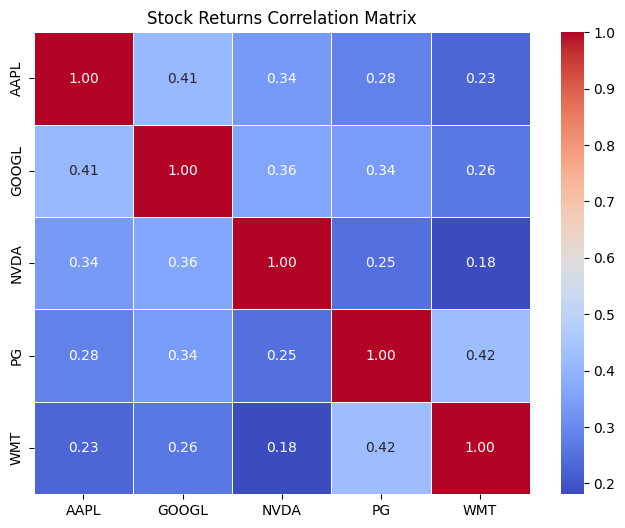

Stocks Data Consistent


In [7]:
stock_symbols = ['NVDA','WMT','AAPL','PG','GOOGL']

plot_stock_correlation(stock_symbols, '2010-01-01', '2016-12-31')

# create stock -> create portfolio -> create backtester 
stocks = [ Stock(
    symbol=symbol,
    start='2010-01-01',
    end='2016-12-31', 
    interval='1d', 
    transcation_cost=0, 
    strategy=CC_RSI_strategy, 
    verbose=True) 
    for symbol in stock_symbols
    ]

CC_RSI_portfolio = Portfolio(
    stocks = dict(zip(stock_symbols, stocks)),
    capital=500000,
    variations=3
    )

backtester = Backtester(
    portfolio = CC_RSI_portfolio,
    variations = CC_RSI_portfolio.variations,
    benchmark = 'SPY'
    )
backtester.prepare_strategy()
backtester.run()

[*********************100%%**********************]  1 of 1 completed
Benchmark Data and Backtest Data Consistent


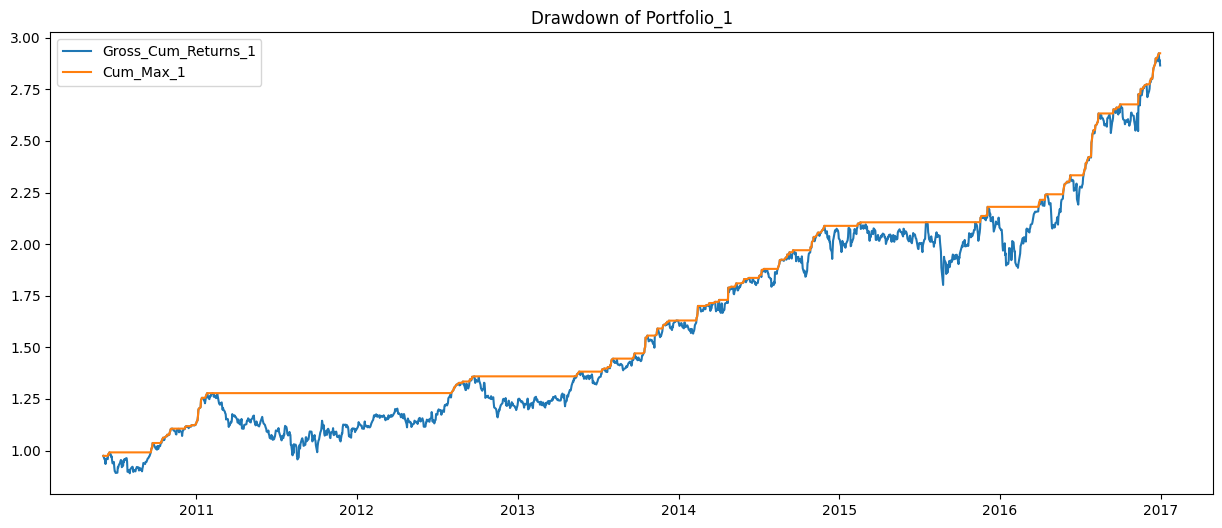

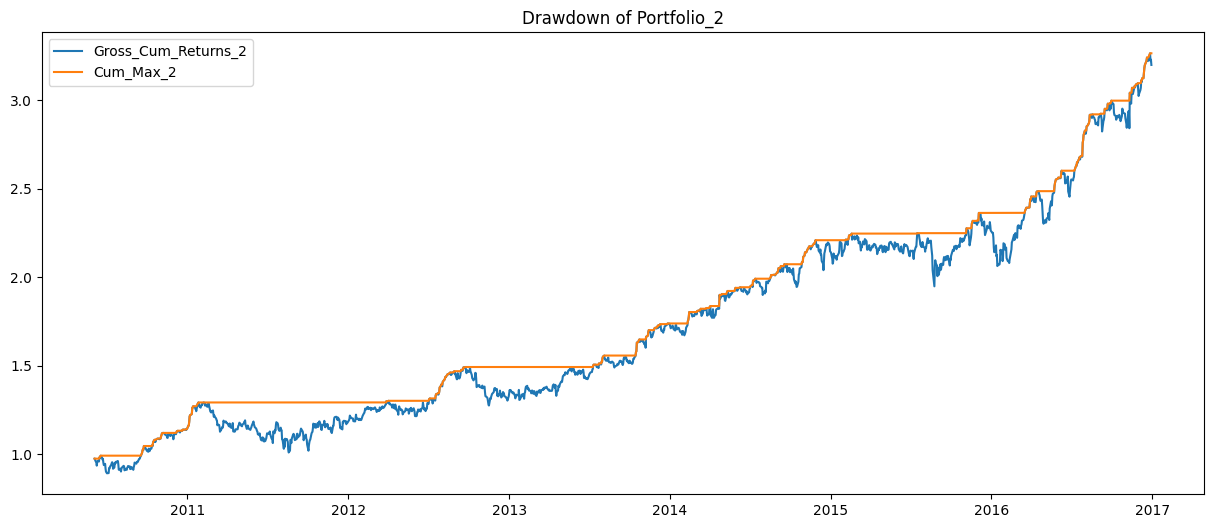

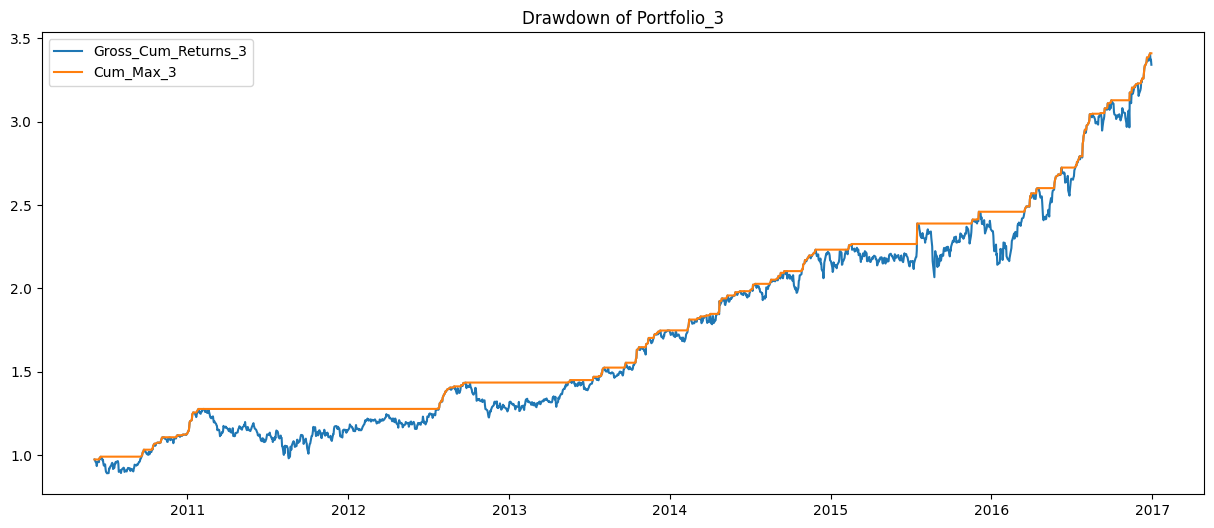

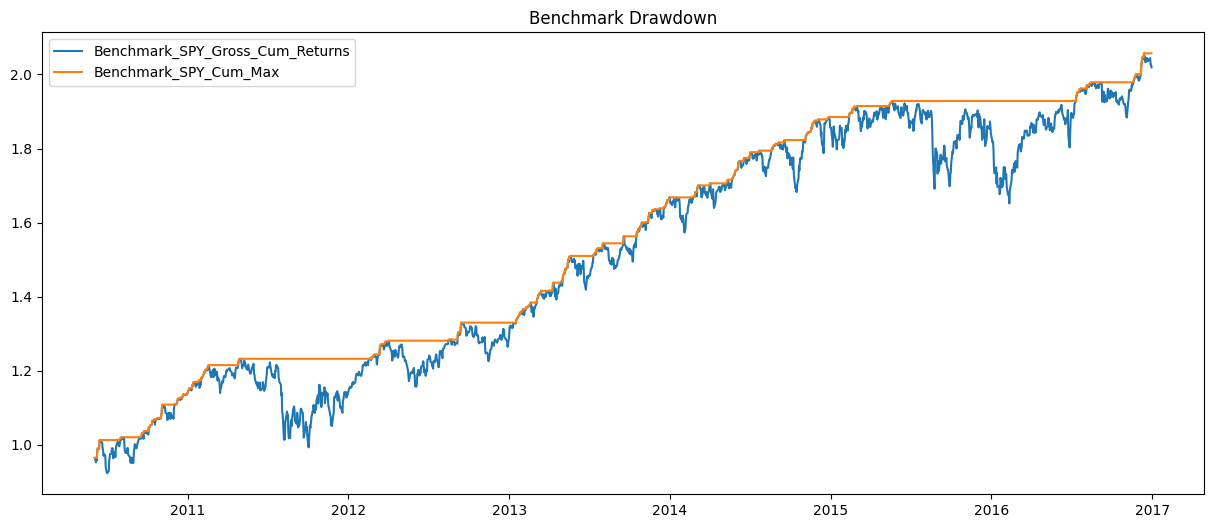

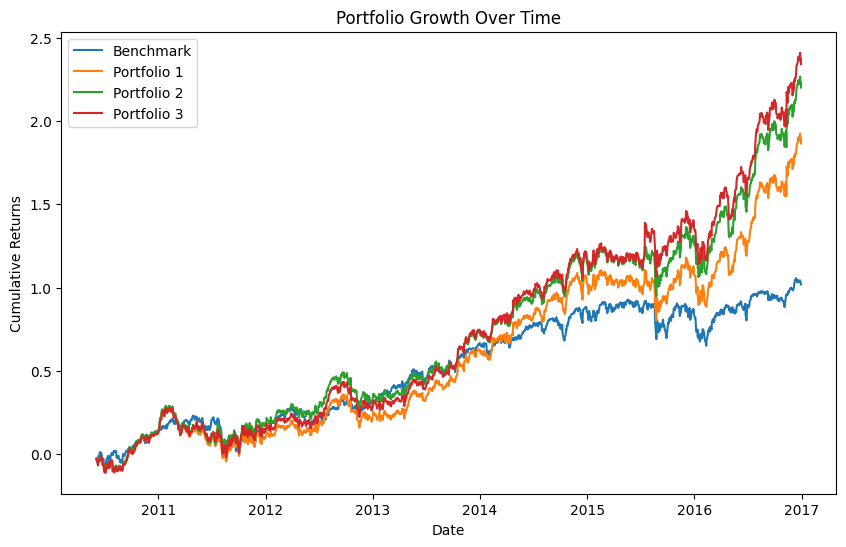

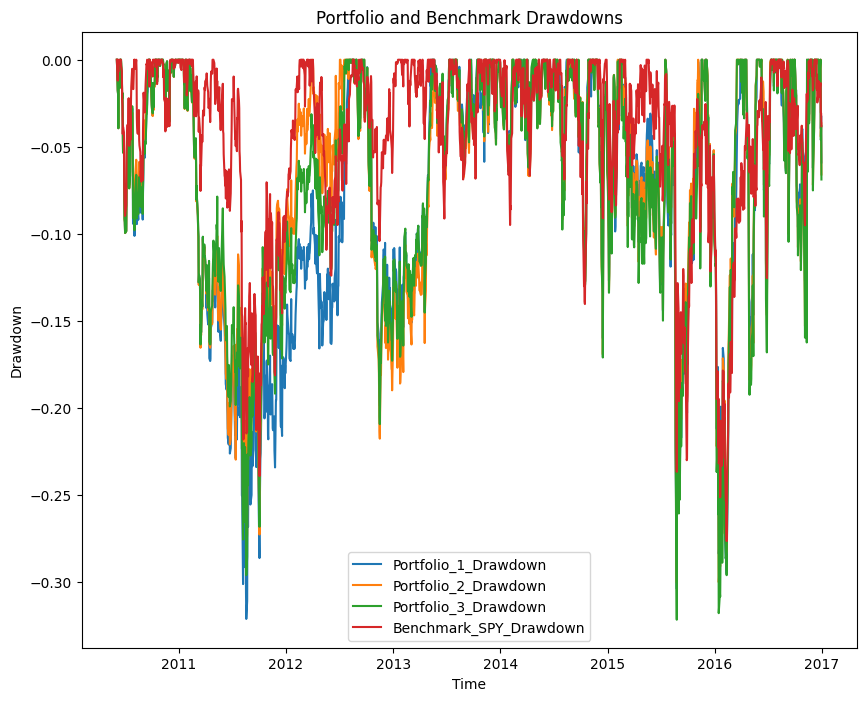

In [8]:
risk_return_df, alpha_beta_df, max_drawdowns_df, calmar_ratio_df, sortino_ratio_df = backtester.overall_stats()

In [9]:
backtester.portfolio.dataframe

,Portfolio_1_value,Portfolio_2_value,Portfolio_3_value,Benchmark_SPY_close,Benchmark_SPY_Returns,Benchmark_SPY_Log_Returns,Portfolio_1_Daily_Returns,Portfolio_1_Log_Returns,Portfolio_2_Daily_Returns,Portfolio_2_Log_Returns,...,Gross_Cum_Returns_3,Cum_Max_3,Portfolio_3_Drawdown,Benchmark_SPY_Gross_Cum_Returns,Benchmark_SPY_Cum_Max,Benchmark_SPY_Drawdown,Benchmark_SPY_Cumulative,Portfolio_1_Cumulative,Portfolio_2_Cumulative,Portfolio_3_Cumulative
2010-06-03,5.000000e+05,5.000000e+05,5.000000e+05,110.709999,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,4.870246e+05,4.870246e+05,4.870246e+05,106.820000,-0.035137,-0.035769,-0.025951,-0.026293,-0.025951,-0.026293,...,0.974049,0.974049,0.000000,0.964863,0.964863,0.000000,-0.035137,-0.025951,-0.025951,-0.025951
2010-06-07,4.781816e+05,4.781816e+05,4.781816e+05,105.489998,-0.012451,-0.012529,-0.018157,-0.018324,-0.018157,-0.018324,...,0.956363,0.974049,0.017686,0.952850,0.964863,0.012013,-0.047150,-0.043637,-0.043637,-0.043637
2010-06-08,4.772336e+05,4.772336e+05,4.772336e+05,106.620003,0.010712,0.010655,-0.001982,-0.001984,-0.001982,-0.001984,...,0.954467,0.974049,0.019582,0.963057,0.964863,0.001806,-0.036943,-0.045533,-0.045533,-0.045533
2010-06-09,4.673356e+05,4.673356e+05,4.673356e+05,106.050003,-0.005346,-0.005360,-0.020740,-0.020958,-0.020740,-0.020958,...,0.934671,0.974049,0.039378,0.957908,0.964863,0.006955,-0.042092,-0.065329,-0.065329,-0.065329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,1.447339e+06,1.616811e+06,1.687489e+06,225.710007,0.001464,0.001463,0.003439,0.003433,0.003439,0.003433,...,3.374978,3.384819,0.009842,2.038750,2.057267,0.018517,1.038750,1.894679,2.233623,2.374978
2016-12-27,1.462289e+06,1.633511e+06,1.704919e+06,226.270004,0.002481,0.002478,0.010329,0.010276,0.010329,0.010276,...,3.409839,3.409839,0.000000,2.043808,2.057267,0.013458,1.043808,1.924577,2.267022,2.409839
2016-12-28,1.442492e+06,1.611396e+06,1.681838e+06,224.399994,-0.008265,-0.008299,-0.013538,-0.013631,-0.013538,-0.013631,...,3.363675,3.409839,0.046164,2.026917,2.057267,0.030350,1.026917,1.884984,2.222793,2.363675
2016-12-29,1.446168e+06,1.615503e+06,1.686124e+06,224.350006,-0.000223,-0.000223,0.002548,0.002545,0.002548,0.002545,...,3.372247,3.409839,0.037592,2.026466,2.057267,0.030801,1.026466,1.892336,2.231006,2.372247


In [10]:
max_drawdowns_df

,Portfolio_1_Drawdown,Portfolio_2_Drawdown,Portfolio_3_Drawdown
0,0.321493,0.30078,0.321941


In [11]:
risk_return_df

,Portfolio_1,Portfolio_2,Portfolio_3,Benchmark_SPY
Annual_regular_returns,0.173634,0.193565,0.201357,0.112776
Annual_regular_std,0.177910,0.176757,0.179239,0.151973
Annual_sharpe_ratio,0.975962,1.095093,1.123396,0.742079


In [12]:
alpha_beta_df

,Portfolio_1,Portfolio_2,Portfolio_3
Alpha,7.05,8.83,9.53
Beta,0.89,0.88,0.88


In [13]:
calmar_ratio_df 

,Portfolio_1,Portfolio_2,Portfolio_3
Calmar Ratio,0.498004,0.588285,0.569829


In [14]:
sortino_ratio_df

,Portfolio_1,Portfolio_2,Portfolio_3
Sortino Ratio,1.287421,1.466536,1.49308


In [15]:
backtester.yearly_stats()

{2010:                         Portfolio_1  Portfolio_2  Portfolio_3  Benchmark_SPY
 Annual_regular_returns     0.225987     0.255433     0.227273       0.244045
 Annual_regular_std         0.185633     0.178935     0.185999       0.167545
 Annual_sharpe_ratio        1.217390     1.427518     1.221909       1.456599,
 2011:                         Portfolio_1  Portfolio_2  Portfolio_3  Benchmark_SPY
 Annual_regular_returns    -0.025097     0.029268     0.014388      -0.001988
 Annual_regular_std         0.244362     0.247187     0.244500       0.230115
 Annual_sharpe_ratio       -0.102703     0.118406     0.058847      -0.008639,
 2012:                         Portfolio_1  Portfolio_2  Portfolio_3  Benchmark_SPY
 Annual_regular_returns     0.110695     0.130145     0.126123       0.135889
 Annual_regular_std         0.161624     0.161287     0.160715       0.128008
 Annual_sharpe_ratio        0.684889     0.806917     0.784765       1.061570,
 2013:                         Portfolio_1 

### Testing Period

Stocks Data Consistent
[*********************100%%**********************]  1 of 1 completed
Benchmark Data and Backtest Data Consistent


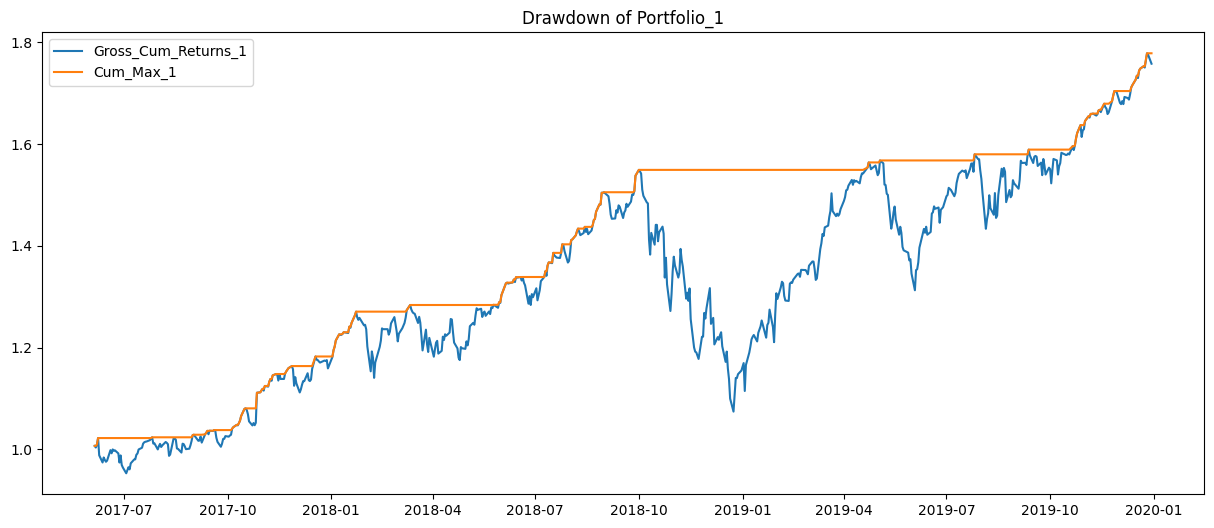

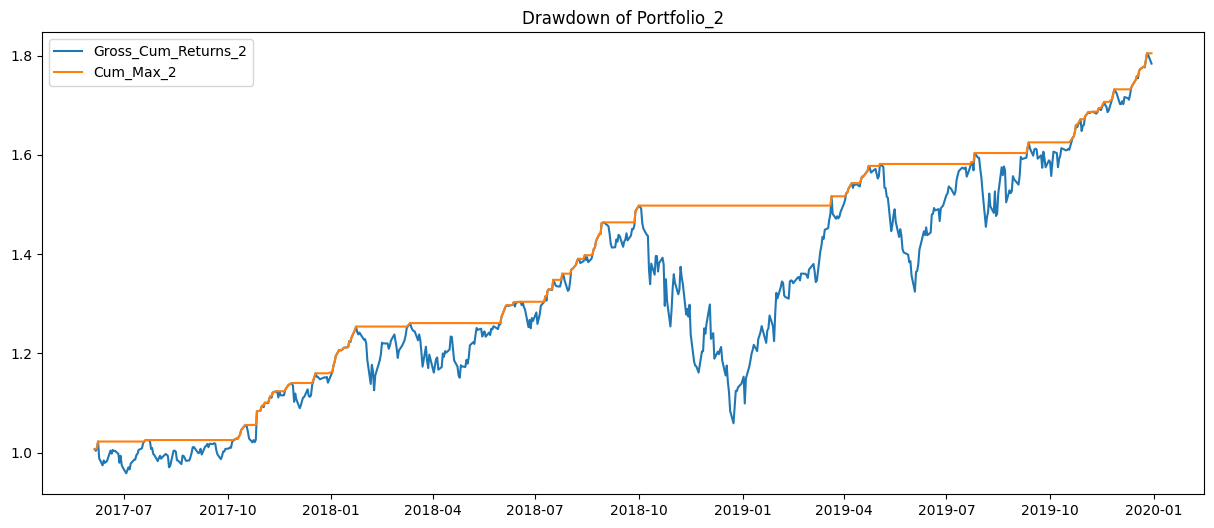

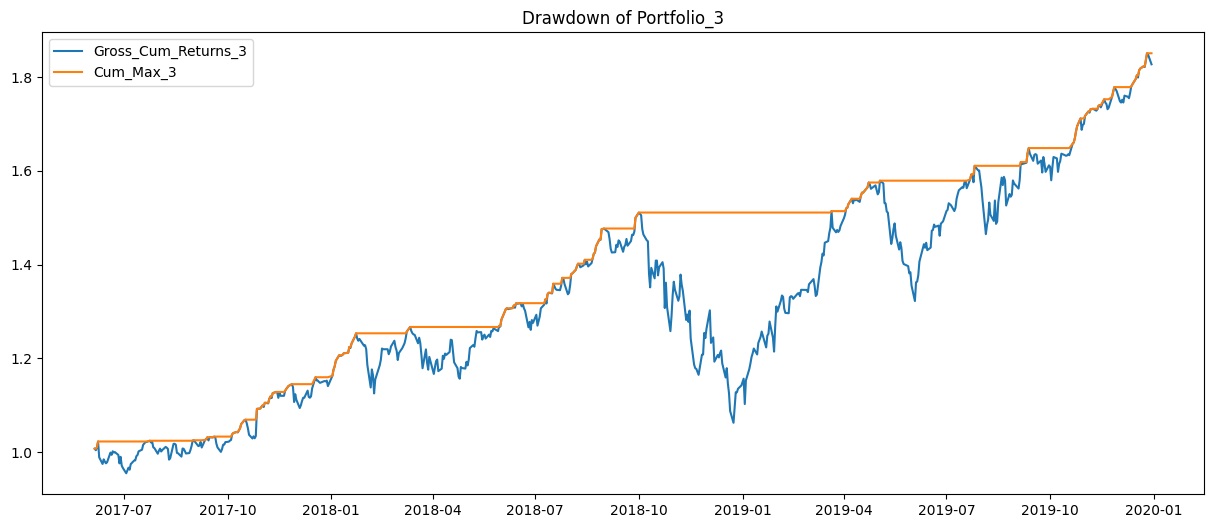

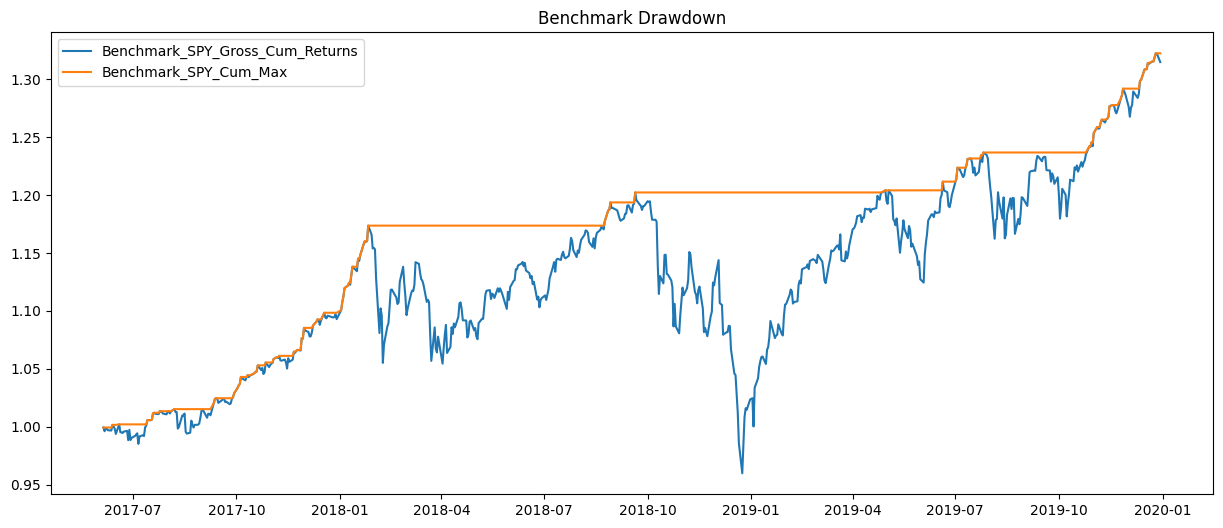

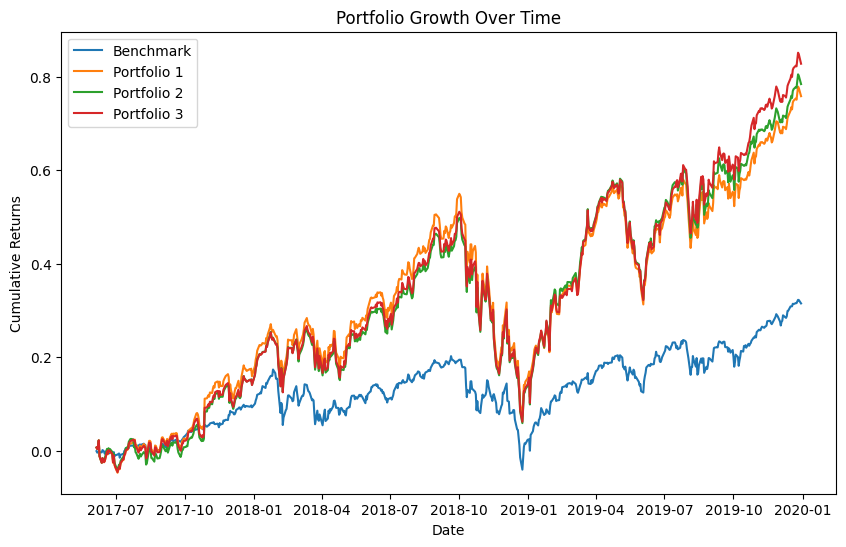

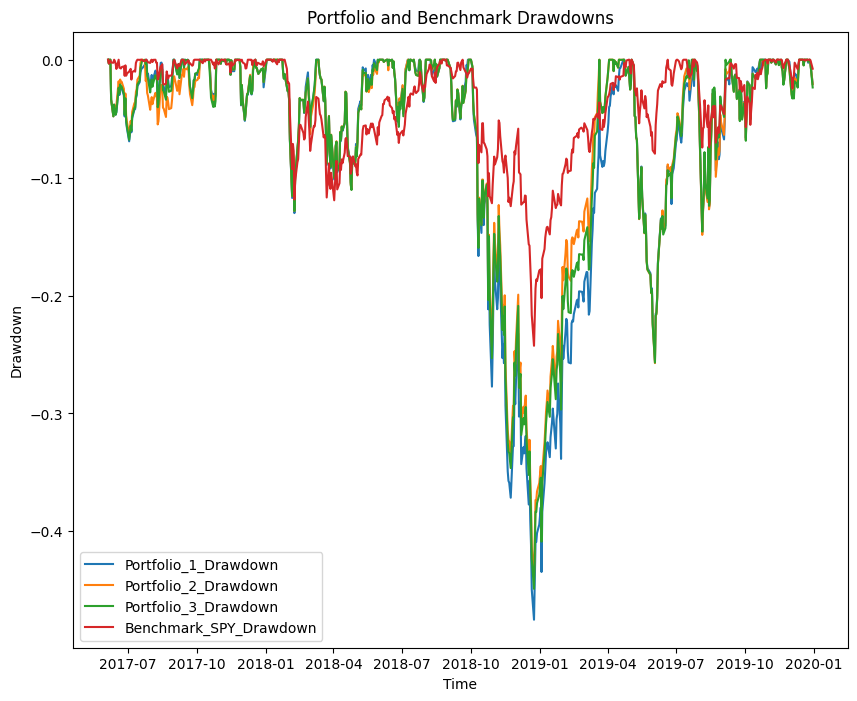

ValueError: too many values to unpack (expected 4)

In [16]:
# One shot run code

stock_symbols = ['NVDA','AMZN','AAPL','PG','GOOGL']

stocks = [ Stock(
    symbol=symbol,
    start='2017-01-01',
    end='2019-12-31', 
    interval='1d', 
    transcation_cost=0, 
    strategy=CC_RSI_strategy, 
    verbose=True) 
    for symbol in stock_symbols
    ]

CC_RSI_portfolio = Portfolio(
    stocks = dict(zip(stock_symbols, stocks)),
    capital=500000,
    variations=3
    )

backtester_test = Backtester(
    portfolio = CC_RSI_portfolio,
    variations = CC_RSI_portfolio.variations,
    benchmark='SPY'
    )

backtester_test.prepare_strategy()
backtester_test.run()
risk_return_df, alpha_beta_df,max_drawdowns_df, calmar_ratio_df = backtester_test.overall_stats()

In [ ]:
max_drawdowns_df

,Portfolio_1_Drawdown,Portfolio_2_Drawdown,Portfolio_3_Drawdown
0,0.474962,0.43859,0.44876


In [ ]:
risk_return_df

,Portfolio_1,Portfolio_2,Portfolio_3,Benchmark_SPY
Annual_regular_returns,0.245319,0.252413,0.264204,0.112364
Annual_regular_std,0.223758,0.224362,0.224150,0.135899
Annual_sharpe_ratio,1.096362,1.125024,1.178694,0.826823


In [ ]:
alpha_beta_df

,Portfolio_1,Portfolio_2,Portfolio_3
Alpha,8.37,8.95,10.00
Beta,1.39,1.39,1.38


In [ ]:
calmar_ratio_df

,Portfolio_1,Portfolio_2,Portfolio_3
Calmar Ratio,0.461915,0.513172,0.522424
